<a href="https://colab.research.google.com/github/FRJackson/hw/blob/main/45hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =============== GR5245 HW2 — Q1(a): 准备 Fashion-MNIST 数据与 DataLoader ===============

import os                                   # 标准库：处理文件/路径
import random                                # 标准库：设置随机种子（Python 层）
import numpy as np                           # 科学计算库：设置随机种子（NumPy 层）
import torch                                 # PyTorch 主库
from torch.utils.data import DataLoader      # DataLoader 用于按批量加载数据
from torchvision import datasets, transforms # torchvision 提供常用数据集与图像变换

# —— 1) 可复现实验：统一设置随机种子（保证后续不同学习率调度对比更公平）——
SEED = 5245                                  # 固定一个种子值（课程号方便记忆）
random.seed(SEED)                            # Python 随机数生成器设种子
np.random.seed(SEED)                         # NumPy 随机数生成器设种子
torch.manual_seed(SEED)                      # PyTorch CPU 随机数设种子
torch.cuda.manual_seed_all(SEED)             # 若有多块 GPU，则为所有 GPU 设种子
torch.backends.cudnn.deterministic = True    # 让 cuDNN 使用确定性算法（可复现）
torch.backends.cudnn.benchmark = False       # 关闭自动算法搜索，避免不同运行差异

# —— 2) 设备信息（后续训练会用到；此处仅打印以便确认环境）——
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 若有 GPU 就用 GPU
print(f"Using device: {device}")               # 打印当前设备（cuda 或 cpu）

# —— 3) 指定数据下载/缓存目录 ——
data_root = os.path.join(os.getcwd(), "data")  # 将数据存到当前工作目录下的 data/ 文件夹

# —— 4) 定义图像预处理/变换 ——
# Fashion-MNIST 是单通道 28x28 灰度图；ToTensor 把像素从 [0,255] 映射到 [0,1] 并转成 (C,H,W)
# Normalize((0.5,), (0.5,)) 将其线性缩放到大致 [-1,1]，对训练更稳定，且后续各模型公平可比
transform = transforms.Compose([
    transforms.ToTensor(),                    # 转张量，数值缩放到 [0,1]，形状变为 [1,28,28]
    transforms.Normalize((0.5,), (0.5,))      # 使用均值0.5、方差0.5做标准化（单通道只填一个数）
])

# —— 5) 构建训练/验证数据集 ——
# train=True 下载训练集；train=False 下载官方测试集（本作业充当“验证集”使用）
train_dataset = datasets.FashionMNIST(
    root=data_root, train=True, download=True, transform=transform
)                                             # 训练集：6万张图像
val_dataset = datasets.FashionMNIST(
    root=data_root, train=False, download=True, transform=transform
)                                             # 验证集：1万张图像（官方测试集）

# —— 6) 构建 DataLoader（训练批量大小按题目要求设为64）——
BATCH_SIZE = 64                               # 题目指定：训练时使用 64 个样本的 minibatch
num_workers = min(4, os.cpu_count() or 0)     # 选择合适的加载线程数（不宜过大，兼顾通用性）
pin_memory = (device.type == "cuda")          # 若用 GPU，pin_memory=True 可加速主机→GPU 拷贝

train_loader = DataLoader(
    dataset=train_dataset,                    # 指定数据集：训练集
    batch_size=BATCH_SIZE,                    # 每个 batch 64 个样本（题目要求）
    shuffle=True,                             # 打乱训练数据顺序，提升泛化
    num_workers=num_workers,                  # 后台数据加载线程数
    pin_memory=pin_memory,                    # 若用 GPU，固定内存页可略提速
    drop_last=False                           # 不丢弃最后不足一个批次的数据
)

val_loader = DataLoader(
    dataset=val_dataset,                      # 指定数据集：验证集（用官方测试集充当）
    batch_size=BATCH_SIZE,                    # 设同样的 batch 大小，便于统一代码
    shuffle=False,                            # 验证/测试不需要打乱
    num_workers=num_workers,                  # 同上
    pin_memory=pin_memory,                    # 同上
    drop_last=False                           # 验证集不丢弃最后批
)

# —— 7) 方便调试：打印类别名与取一个批次做形状检查（可保留，后续训练也有用）——
class_names = train_dataset.classes           # 官方给出的 10 个类别名列表
print("Classes:", class_names)                # 打印类别（如 'T-shirt/top', 'Trouser', ...）

images, targets = next(iter(train_loader))    # 从训练加载器里抓一个批次（不送入模型，仅检查）
print("Train batch — images shape:", images.shape, "targets shape:", targets.shape)
# 预期输出形状：images [64, 1, 28, 28]；targets [64]，表示每张图的类别索引(0~9)

# 额外：观察归一化后像素范围，大致应接近 [-1,1]
print("Pixel range after Normalize (approx):", float(images.min()), "to", float(images.max()))

# 说明：
# - 以上即完成了第 (a) 小问的全部要求：下载数据并准备好训练/验证 DataLoader。
# - 你后续在 (b)–(f) 中只需复用 train_loader / val_loader 即可进入模型训练与调度器比较。


Using device: cpu


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.03MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.91MB/s]

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Train batch — images shape: torch.Size([64, 1, 28, 28]) targets shape: torch.Size([64])
Pixel range after Normalize (approx): -1.0 to 1.0


In [2]:
# =============== GR5245 HW2 — Q1(b): 使用 StepLR 训练 10 个 epoch（按 epoch 更新） ===============

import math                                  # 标准库：可选，用于一些数学操作（这里主要备用）
import torch                                  # PyTorch 主库
import torch.nn as nn                         # 神经网络模块
import torch.nn.functional as F               # 常用函数式API（此处备用）
from torch.optim import SGD                   # 优化器：随机梯度下降（无动量）
from torch.optim.lr_scheduler import StepLR   # 学习率调度器：StepLR（按周期乘以 gamma）
from typing import Dict, List                 # 类型注解（可读性更好）

# —— 0) 保障：若用户未先运行(a)，给出直观报错 ——
assert 'train_loader' in globals() and 'val_loader' in globals(), \
    "未检测到 train_loader/val_loader。请先运行 Q1(a) 的数据准备代码。"

# —— 1) 设备与随机种子（与(a)保持一致，确保公平、可复现）——
SEED = globals().get('SEED', 5245)           # 若(a)已定义 SEED=5245，则复用；否则设为 5245
torch.manual_seed(SEED)                      # 固定 PyTorch 随机数种子（确保初始化一致）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 有 GPU 则用 GPU

# —— 2) 定义符合题目要求的前馈网络：Flatten→Linear(256,ReLU)→Dropout(0.3)→Linear(128,ReLU)→Dropout(0.3)→Linear(10) ——
class MLP(nn.Module):                        # 继承 nn.Module 定义多层感知机
    def __init__(self):                      # 初始化网络结构
        super().__init__()                   # 调用父类构造函数
        self.flatten = nn.Flatten()          # 将输入图像展平为长度 784 的向量（28×28）
        self.fc1 = nn.Linear(784, 256)       # 第一层全连接：784→256
        self.do1 = nn.Dropout(p=0.3)         # Dropout 层，丢弃率 30%
        self.fc2 = nn.Linear(256, 128)       # 第二层全连接：256→128
        self.do2 = nn.Dropout(p=0.3)         # 第二个 Dropout 层，丢弃率 30%
        self.fc3 = nn.Linear(128, 10)        # 最后一层全连接：128→10（输出 logits）

    def forward(self, x):                    # 前向传播定义
        x = self.flatten(x)                  # [B,1,28,28] → [B,784]
        x = F.relu(self.fc1(x))              # 线性层 + ReLU
        x = self.do1(x)                      # 应用 Dropout（仅训练时生效）
        x = F.relu(self.fc2(x))              # 第二层 + ReLU
        x = self.do2(x)                      # 再次 Dropout
        logits = self.fc3(x)                 # 输出未归一化分数（logits）
        return logits                        # 返回 logits（交叉熵会内部做 softmax）

# —— 3) 自定义一个权重初始化函数：确保各实验起点一致 & 合理 ——
def init_weights(m):                         # 定义初始化规则，便于在不同实验复用
    if isinstance(m, nn.Linear):             # 仅对 Linear 层进行初始化
        nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))  # Kaiming 均匀初始化（ReLU 友好）
        if m.bias is not None:               # 若存在偏置
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)  # 计算 fan_in
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0           # 计算偏置范围
            nn.init.uniform_(m.bias, -bound, bound)                      # 偏置均匀初始化

# —— 4) 构建模型并应用初始化（再次设种子以确保(b)(c)(d)完全同起点）——
torch.manual_seed(SEED)                      # 再次设种子，确保每次 new 模型都一样
model = MLP().to(device)                     # 实例化模型并移动到设备
model.apply(init_weights)                    # 应用自定义初始化（保证跨实验公平）

# —— 5) 定义损失函数与优化器（按题目：CrossEntropy + SGD(lr=0.1, 无动量)）——
criterion = nn.CrossEntropyLoss()            # 交叉熵用于多分类
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.0)  # SGD，学习率 0.1，无动量

# —— 6) 定义 StepLR 学习率调度器（按 epoch 更新，gamma=0.5）——
#     由于本题要求“按 epoch 更新”，我们设置 step_size=1 表示每个 epoch 调整一次 LR。
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)  # 每个 epoch 将 LR 乘以 0.5

# —— 7) 训练参数与历史记录容器 ——
EPOCHS = 10                                  # 题目要求训练 10 个 epoch
history: Dict[str, List[float]] = {          # 用字典保存曲线，供(e)作图使用
    "train_loss": [],                        # 每个 epoch 的训练集平均损失
    "val_loss": [],                          # 每个 epoch 的验证集平均损失
    "val_acc": [],                           # 每个 epoch 的验证集准确率（0~1）
    "lr": []                                 # 每个 epoch 的学习率（记录调度器作用）
}

# —— 8) 训练与验证循环（10 个 epoch，按 epoch 更新学习率）——
for epoch in range(1, EPOCHS + 1):           # 遍历 1..EPOCHS
    model.train()                            # 切换到训练模式（启用 Dropout/BN 等）
    running_loss = 0.0                       # 累计训练损失（用于求平均）
    total_train = 0                          # 累计训练样本数
    # —— 8.1) 训练阶段 ——
    for images, targets in train_loader:     # 从训练 DataLoader 逐批读取
        images = images.to(device, non_blocking=True)  # 将图像拷贝到设备（GPU/CPU）
        targets = targets.to(device, non_blocking=True)# 将标签拷贝到设备

        optimizer.zero_grad()                # 梯度清零（每个小批次都需要）
        logits = model(images)               # 前向传播，得到 logits
        loss = criterion(logits, targets)    # 计算交叉熵损失
        loss.backward()                      # 反向传播，计算梯度
        optimizer.step()                     # 参数更新（基于当前学习率）

        batch_size = images.size(0)          # 当前批次样本数（最后一批可能不足 64）
        running_loss += loss.item() * batch_size  # 累加“总损失”方便求全局平均
        total_train += batch_size            # 累加总样本数

    avg_train_loss = running_loss / total_train      # 该 epoch 的训练平均损失

    # —— 8.2) 验证阶段 ——
    model.eval()                             # 切换到评估模式（关闭 Dropout/BN 的更新）
    val_loss_sum, val_total, val_correct = 0.0, 0, 0 # 初始化验证统计量
    with torch.inference_mode():             # 关闭梯度，节省显存与加速推理
        for images, targets in val_loader:   # 遍历验证 DataLoader
            images = images.to(device, non_blocking=True)  # 拷贝到设备
            targets = targets.to(device, non_blocking=True)# 拷贝到设备
            logits = model(images)           # 前向传播
            loss = criterion(logits, targets)# 计算验证损失
            # 统计损失
            bs = images.size(0)              # 当前批次大小
            val_loss_sum += loss.item() * bs # 累计损失总和
            val_total += bs                  # 累计样本总数
            # 统计准确率
            preds = logits.argmax(dim=1)     # 取每行最大 logit 的类别索引
            val_correct += (preds == targets).sum().item()  # 统计预测正确数

    avg_val_loss = val_loss_sum / val_total          # 该 epoch 的验证平均损失
    val_acc = val_correct / val_total                # 该 epoch 的验证准确率（0~1）

    # —— 8.3) 记录学习率（调度前的当前 LR），打印可视化 ——
    current_lr = optimizer.param_groups[0]['lr']     # 读取优化器当前学习率
    history["train_loss"].append(avg_train_loss)     # 记录训练损失
    history["val_loss"].append(avg_val_loss)         # 记录验证损失
    history["val_acc"].append(val_acc)               # 记录验证准确率
    history["lr"].append(current_lr)                 # 记录学习率（方便(e)对比曲线）

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"LR={current_lr:.5f} | "
          f"TrainLoss={avg_train_loss:.4f} | "
          f"ValLoss={avg_val_loss:.4f} | "
          f"ValAcc={val_acc:.4f}")                   # 控制台打印该 epoch 指标

    # —— 8.4) 按“epoch”为单位更新学习率（StepLR 每个 epoch × gamma）——
    scheduler.step()                                  # 关键：在 epoch 末调用，下一轮将使用新 LR

# —— 9) 训练完成后，可选择返回或使用 history（供(e)画图对比用）——
print("训练完成。可使用 `history` 字典绘制损失/准确率/学习率曲线，用于 (e) 的比较。")
# history 字段说明：
#   history["train_loss"] : List[float]，长度=EPOCHS
#   history["val_loss"]   : List[float]，长度=EPOCHS
#   history["val_acc"]    : List[float]，长度=EPOCHS
#   history["lr"]         : List[float]，长度=EPOCHS


Epoch 01/10 | LR=0.10000 | TrainLoss=0.6321 | ValLoss=0.4771 | ValAcc=0.8272
Epoch 02/10 | LR=0.05000 | TrainLoss=0.4350 | ValLoss=0.4264 | ValAcc=0.8464
Epoch 03/10 | LR=0.02500 | TrainLoss=0.3922 | ValLoss=0.3922 | ValAcc=0.8558
Epoch 04/10 | LR=0.01250 | TrainLoss=0.3754 | ValLoss=0.3775 | ValAcc=0.8625
Epoch 05/10 | LR=0.00625 | TrainLoss=0.3651 | ValLoss=0.3757 | ValAcc=0.8647
Epoch 06/10 | LR=0.00313 | TrainLoss=0.3606 | ValLoss=0.3707 | ValAcc=0.8655
Epoch 07/10 | LR=0.00156 | TrainLoss=0.3562 | ValLoss=0.3704 | ValAcc=0.8665
Epoch 08/10 | LR=0.00078 | TrainLoss=0.3558 | ValLoss=0.3695 | ValAcc=0.8655
Epoch 09/10 | LR=0.00039 | TrainLoss=0.3548 | ValLoss=0.3692 | ValAcc=0.8663
Epoch 10/10 | LR=0.00020 | TrainLoss=0.3549 | ValLoss=0.3691 | ValAcc=0.8667
训练完成。可使用 `history` 字典绘制损失/准确率/学习率曲线，用于 (e) 的比较。


In [6]:
# =============== GR5245 HW2 — Q1(c): 使用 CosineAnnealingLR（按 minibatch 更新）训练 10 个 epoch ===============

import math                                      # 标准库：数学函数（用于初始化计算范围等）
import torch                                     # PyTorch 主库
import torch.nn as nn                            # 神经网络模块
import torch.nn.functional as F                  # 常用函数式 API（此处用于 ReLU）
from torch.optim import SGD                      # 优化器：随机梯度下降（无动量）
from torch.optim.lr_scheduler import CosineAnnealingLR  # 余弦退火学习率调度器
from typing import Dict, List                    # 类型注解，提高可读性

# —— 0) 保障：确保已准备好数据加载器（来自第(a)步）——
assert 'train_loader' in globals() and 'val_loader' in globals(), \
    "未检测到 train_loader/val_loader。请先运行 Q1(a) 的数据准备代码。"

# —— 1) 设备与随机种子（与前面保持一致，保证公平与可复现）——
SEED = globals().get('SEED', 5245)               # 读取(a)里定义的 SEED；若无则设为 5245
torch.manual_seed(SEED)                          # 固定 PyTorch 随机数种子
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 自动选择 GPU/CPU

# —— 2) 定义与题目一致的前馈网络结构 ——
class MLP(nn.Module):                            # 多层感知机：Flatten→Linear→Dropout→Linear→Dropout→Linear
    def __init__(self):                          # 构造函数：声明各层
        super().__init__()                       # 初始化父类
        self.flatten = nn.Flatten()              # 将 [B,1,28,28] 展平成 [B,784]
        self.fc1 = nn.Linear(784, 256)           # 第一全连接层：784→256
        self.do1 = nn.Dropout(p=0.3)             # Dropout：丢弃 30%
        self.fc2 = nn.Linear(256, 128)           # 第二全连接层：256→128
        self.do2 = nn.Dropout(p=0.3)             # 再次 Dropout：丢弃 30%
        self.fc3 = nn.Linear(128, 10)            # 输出层：128→10（logits）

    def forward(self, x):                        # 前向传播：定义数据如何流经各层
        x = self.flatten(x)                      # 展平为 784 维
        x = F.relu(self.fc1(x))                  # 线性 + ReLU
        x = self.do1(x)                          # 训练时随机丢弃部分神经元
        x = F.relu(self.fc2(x))                  # 第二层 + ReLU
        x = self.do2(x)                          # 再次 Dropout
        logits = self.fc3(x)                     # 得到 10 维 logits（未做 softmax）
        return logits                            # 返回 logits，交叉熵内部会做 softmax

# —— 3) 自定义初始化：确保不同实验起点一致（提高对比公平性）——
def init_weights(m):                             # 对 Linear 层使用 Kaiming 均匀初始化
    if isinstance(m, nn.Linear):                 # 仅处理全连接层
        nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))  # 适配 ReLU 的初始化
        if m.bias is not None:                   # 若存在 bias，则均匀初始化到一个合理范围
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(m.bias, -bound, bound)

# —— 4) 实例化模型并应用初始化 ——
torch.manual_seed(SEED)                          # 再设一次种子，保证模型权重可复现
model_c = MLP().to(device)                       # 实例化模型并移动到设备（GPU/CPU）
model_c.apply(init_weights)                      # 应用自定义初始化

# —— 5) 定义损失函数与优化器（与题目一致）——
criterion = nn.CrossEntropyLoss()                # 多分类交叉熵损失
optimizer = SGD(model_c.parameters(), lr=0.1, momentum=0.0)  # SGD，学习率 0.1，无动量

# —— 6) 定义“按 minibatch 更新”的 CosineAnnealingLR ——
EPOCHS = 10                                      # 本题要求训练 10 个 epoch
steps_per_epoch = len(train_loader)              # 每个 epoch 的 batch 数（步数）
total_steps = EPOCHS * steps_per_epoch           # 余弦退火的总迭代步数（T_max 需为“总步数”）
scheduler = CosineAnnealingLR(                   # 构建余弦退火调度器
    optimizer,                                   # 绑定的优化器
    T_max=total_steps,                           # 在 total_steps 次 step() 后将 LR 退火到 eta_min
    eta_min=0.001                                # 题目指定的最小学习率
)                                                # 注意：我们将在“每个 batch”后调用 scheduler.step()

# —— 7) 训练记录容器：为 (e) 画图做准备（单独命名避免覆盖(b)的 history）——
history_c: Dict[str, List[float]] = {            # 保存每个 epoch 的指标与每步的学习率
    "train_loss": [],                            # 每个 epoch 的训练平均损失
    "val_loss": [],                              # 每个 epoch 的验证平均损失
    "val_acc": [],                               # 每个 epoch 的验证准确率
    "lr_epoch_end": [],                          # 每个 epoch 结束时的学习率
    "lr_steps": []                               # 训练过程中“每个 batch”的学习率（长度≈total_steps）
}

# —— 8) 训练与验证循环（关键：在每个 batch 完成 optimizer.step() 之后立刻 scheduler.step()）——
global_step = 0                                  # 记录已执行的 batch 步数（方便调度与打印）
for epoch in range(1, EPOCHS + 1):               # 外层循环：共 10 个 epoch
    model_c.train()                               # 切换训练模式（启用 Dropout）
    running_loss, total_train = 0.0, 0           # 本 epoch 的累计训练损失与样本数

    # —— 8.1) 训练阶段（按 batch 更新学习率）——
    for images, targets in train_loader:         # 遍历每一个 minibatch
        images = images.to(device, non_blocking=True)   # 将图像张量拷贝到设备
        targets = targets.to(device, non_blocking=True) # 将标签拷贝到设备

        optimizer.zero_grad()                    # 清空上一批次的梯度
        logits = model_c(images)                 # 前向传播，得到 logits
        loss = criterion(logits, targets)        # 计算当前批次的交叉熵损失
        loss.backward()                          # 反向传播，计算梯度
        optimizer.step()                         # 使用当前学习率进行一次参数更新

        scheduler.step()                         # 关键：在“每个 batch”后调用一次调度器（余弦退火一步）
        current_lr = optimizer.param_groups[0]["lr"]  # 读取调度后的当前学习率
        history_c["lr_steps"].append(current_lr) # 记录本批次的学习率，供(e)细粒度作图

        bs = images.size(0)                      # 当前批次大小（最后一批可能不足 64）
        running_loss += loss.item() * bs         # 累加“损失总和”（便于求平均）
        total_train += bs                         # 累加样本数
        global_step += 1                          # 全局步数 +1（用于观察/调试）

    avg_train_loss = running_loss / total_train   # 该 epoch 的训练平均损失

    # —— 8.2) 验证阶段（不更新权重与学习率）——
    model_c.eval()                                # 切换评估模式（关闭 Dropout）
    val_loss_sum, val_total, val_correct = 0.0, 0, 0  # 初始化验证统计
    with torch.inference_mode():                  # 关闭梯度，加速与省显存
        for images, targets in val_loader:        # 遍历验证集
            images = images.to(device, non_blocking=True)  # 拷贝到设备
            targets = targets.to(device, non_blocking=True) # 拷贝到设备
            logits = model_c(images)              # 前向传播
            loss = criterion(logits, targets)     # 计算验证损失
            bs = images.size(0)                   # 批大小
            val_loss_sum += loss.item() * bs      # 累计损失
            val_total += bs                       # 累计样本数
            preds = logits.argmax(dim=1)          # 取预测类别
            val_correct += (preds == targets).sum().item()  # 统计正确数

    avg_val_loss = val_loss_sum / val_total       # 验证平均损失
    val_acc = val_correct / val_total             # 验证准确率（0~1）

    # —— 8.3) 记录该 epoch 的指标与 epoch 末学习率，并打印 ——
    lr_epoch_end = optimizer.param_groups[0]["lr"]  # 读取本 epoch 结束时（最后一个 batch 后）的 LR
    history_c["train_loss"].append(avg_train_loss)  # 记录训练损失
    history_c["val_loss"].append(avg_val_loss)      # 记录验证损失
    history_c["val_acc"].append(val_acc)            # 记录验证准确率
    history_c["lr_epoch_end"].append(lr_epoch_end)  # 记录 epoch 末学习率（用于粗粒度作图）

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"LR(end)={lr_epoch_end:.5f} | "
          f"TrainLoss={avg_train_loss:.4f} | "
          f"ValLoss={avg_val_loss:.4f} | "
          f"ValAcc={val_acc:.4f}")                 # 控制台打印本 epoch 的关键指标

# —— 9) 训练完成：history_c 可直接用于 (e) 绘制对比曲线（含每步与每 epoch 的学习率）——
print("训练完成（CosineAnnealingLR, per-batch）。可使用 history_c 绘制损失/准确率/学习率曲线。")
# history_c 字段说明：
#   history_c["train_loss"]   : List[float]，长度=EPOCHS
#   history_c["val_loss"]     : List[float]，长度=EPOCHS
#   history_c["val_acc"]      : List[float]，长度=EPOCHS
#   history_c["lr_epoch_end"] : List[float]，长度=EPOCHS（每个 epoch 末的 LR）
#   history_c["lr_steps"]     : List[float]，长度≈EPOCHS*len(train_loader)（每个 batch 的 LR）


Epoch 01/10 | LR(end)=0.09758 | TrainLoss=0.6316 | ValLoss=0.4719 | ValAcc=0.8303
Epoch 02/10 | LR(end)=0.09055 | TrainLoss=0.4543 | ValLoss=0.4556 | ValAcc=0.8370
Epoch 03/10 | LR(end)=0.07960 | TrainLoss=0.4059 | ValLoss=0.4073 | ValAcc=0.8497
Epoch 04/10 | LR(end)=0.06580 | TrainLoss=0.3782 | ValLoss=0.3734 | ValAcc=0.8638
Epoch 05/10 | LR(end)=0.05050 | TrainLoss=0.3531 | ValLoss=0.3602 | ValAcc=0.8703
Epoch 06/10 | LR(end)=0.03520 | TrainLoss=0.3328 | ValLoss=0.3519 | ValAcc=0.8729
Epoch 07/10 | LR(end)=0.02140 | TrainLoss=0.3173 | ValLoss=0.3371 | ValAcc=0.8806
Epoch 08/10 | LR(end)=0.01045 | TrainLoss=0.3056 | ValLoss=0.3333 | ValAcc=0.8791
Epoch 09/10 | LR(end)=0.00342 | TrainLoss=0.2970 | ValLoss=0.3319 | ValAcc=0.8810
Epoch 10/10 | LR(end)=0.00100 | TrainLoss=0.2930 | ValLoss=0.3300 | ValAcc=0.8817
训练完成（CosineAnnealingLR, per-batch）。可使用 history_c 绘制损失/准确率/学习率曲线。


In [7]:
# =============== GR5245 HW2 — Q1(d): 使用 OneCycleLR（按 minibatch 更新）训练 10 个 epoch ===============

import math                                         # 标准库：数学函数（用于初始化计算等）
import torch                                        # PyTorch 主库
import torch.nn as nn                               # 神经网络模块
import torch.nn.functional as F                     # 常用函数式 API（本处用于 ReLU）
from torch.optim import SGD                         # 优化器：SGD（无动量）
from torch.optim.lr_scheduler import OneCycleLR     # 学习率调度器：OneCycleLR
from typing import Dict, List                       # 类型注解（提高可读性）

# —— 0) 保障：确保已准备好数据加载器（来自第(a)步）——
assert 'train_loader' in globals() and 'val_loader' in globals(), \
    "未检测到 train_loader/val_loader。请先运行 Q1(a) 的数据准备代码。"

# —— 1) 设备与随机种子（与前面保持一致，保证公平对比与可复现）——
SEED = globals().get('SEED', 5245)                  # 若(a)里已定义 SEED，则复用；否则设为 5245
torch.manual_seed(SEED)                             # 固定 PyTorch 随机数种子
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 自动选择 GPU/CPU

# —— 2) 定义符合题目要求的 MLP 结构 ——
class MLP(nn.Module):                               # 多层感知机：Flatten→Linear→Dropout→Linear→Dropout→Linear
    def __init__(self):                             # 构造函数：声明各层
        super().__init__()                          # 初始化父类
        self.flatten = nn.Flatten()                 # 将 [B,1,28,28] 展平成 [B,784]
        self.fc1 = nn.Linear(784, 256)              # 全连接层1：784→256
        self.do1 = nn.Dropout(p=0.3)                # Dropout：丢弃 30%
        self.fc2 = nn.Linear(256, 128)              # 全连接层2：256→128
        self.do2 = nn.Dropout(p=0.3)                # 第二个 Dropout：丢弃 30%
        self.fc3 = nn.Linear(128, 10)               # 输出层：128→10（logits）

    def forward(self, x):                           # 前向传播：定义数据流
        x = self.flatten(x)                         # 展平为 784 维
        x = F.relu(self.fc1(x))                     # 线性 + ReLU
        x = self.do1(x)                             # 训练时启用 Dropout
        x = F.relu(self.fc2(x))                     # 第二层 + ReLU
        x = self.do2(x)                             # 再次 Dropout
        logits = self.fc3(x)                        # 得到 10 维 logits（未做 softmax）
        return logits                               # 返回 logits（交叉熵内部会做 softmax）

# —— 3) 自定义初始化：确保不同实验起点一致（提高对比公平性）——
def init_weights(m):                                # 对 Linear 层使用 Kaiming 均匀初始化（适配 ReLU）
    if isinstance(m, nn.Linear):                    # 仅处理全连接层
        nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))  # 权重初始化
        if m.bias is not None:                      # 若存在 bias，则均匀初始化到合理范围
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(m.bias, -bound, bound)

# —— 4) 实例化模型并应用初始化 ——
torch.manual_seed(SEED)                             # 再设一次种子，保证模型权重可复现
model_d = MLP().to(device)                          # 实例化模型并移动到设备（GPU/CPU）
model_d.apply(init_weights)                         # 应用自定义初始化

# —— 5) 定义损失函数与优化器（与题目一致：交叉熵 + SGD(lr=0.1, 无动量)）——
criterion = nn.CrossEntropyLoss()                   # 多分类交叉熵损失
optimizer = SGD(model_d.parameters(), lr=0.1, momentum=0.0)  # SGD，学习率 0.1，无动量

# —— 6) 定义 OneCycleLR（按“每个 batch”更新）——
EPOCHS = 10                                         # 本题要求训练 10 个 epoch
steps_per_epoch = len(train_loader)                 # 每个 epoch 的 batch 数
total_steps = EPOCHS * steps_per_epoch              # OneCycle 的总 step 数（需精确匹配训练步数）
# 说明：
# - max_lr=0.1：峰值学习率按题目要求设置为 0.1
# - div_factor=1.0：初始 lr = max_lr / div_factor = 0.1（满足“初始 lr=0.1”的统一规范）
# - final_div_factor=100：末端 lr ≈ 0.1/100 = 0.001（与(c)的 eta_min 量级一致，便于比较）
# - cycle_momentum=False：严格遵循“无动量”设定（否则 OneCycle 会尝试调节 momentum）
scheduler = OneCycleLR(
    optimizer,                                     # 绑定优化器
    max_lr=0.1,                                    # 峰值学习率（题目要求）
    total_steps=total_steps,                        # 总训练步数（EPOCHS × steps_per_epoch）
    pct_start=0.3,                                  # 前 30% 步数保持上升/平台（默认 0.3，常用）
    anneal_strategy='cos',                          # 余弦退火下降（更平滑）
    cycle_momentum=False,                           # 不循环动量（因为题目明确无动量）
    div_factor=1.0,                                 # 初始 lr = 0.1
    final_div_factor=100.0                          # 末端 lr ≈ 0.001
)                                                   # 注意：我们将在“每个 batch”后调用 scheduler.step()

# —— 7) 训练记录容器：为 (e) 画图对比做准备（避免覆盖(b)(c)的 history）——
history_d: Dict[str, List[float]] = {               # 保存每个 epoch 的指标与每步 LR
    "train_loss": [],                               # 每个 epoch 的训练平均损失
    "val_loss": [],                                 # 每个 epoch 的验证平均损失
    "val_acc": [],                                  # 每个 epoch 的验证准确率
    "lr_epoch_end": [],                             # 每个 epoch 结束时的学习率
    "lr_steps": []                                  # 训练过程中“每个 batch”的学习率（长度≈total_steps）
}

# —— 8) 训练与验证循环（关键：每个 batch 完成 optimizer.step() 后立即 scheduler.step()）——
global_step = 0                                     # 记录全局 batch 步数（便于调试与作图）
for epoch in range(1, EPOCHS + 1):                  # 外层循环：共 10 个 epoch
    model_d.train()                                  # 进入训练模式（启用 Dropout）
    running_loss, total_train = 0.0, 0              # 初始化本 epoch 的损失累积与样本数

    # —— 8.1) 训练阶段（按 batch 更新学习率）——
    for images, targets in train_loader:            # 遍历每一个 minibatch
        images = images.to(device, non_blocking=True)    # 将图像拷贝到设备
        targets = targets.to(device, non_blocking=True)  # 将标签拷贝到设备

        optimizer.zero_grad()                       # 清空上一批的梯度
        logits = model_d(images)                    # 前向传播获得 logits
        loss = criterion(logits, targets)           # 计算当前批次的交叉熵损失
        loss.backward()                             # 反向传播计算梯度
        optimizer.step()                            # 用当前学习率进行一次参数更新

        scheduler.step()                            # 关键：每个 batch 后调用一次 OneCycleLR
        current_lr = optimizer.param_groups[0]["lr"]# 读取调度后的当前学习率
        history_d["lr_steps"].append(current_lr)    # 记录本批次学习率，供(e)细粒度作图

        bs = images.size(0)                         # 当前批次大小（最后一批可能不足 64）
        running_loss += loss.item() * bs            # 累加“损失总和”（便于求平均）
        total_train += bs                            # 累加样本数
        global_step += 1                             # 全局步数 +1（用于检查 total_steps 是否匹配）

    avg_train_loss = running_loss / total_train      # 该 epoch 的训练平均损失

    # —— 8.2) 验证阶段（不更新权重与学习率）——
    model_d.eval()                                   # 切换评估模式（关闭 Dropout）
    val_loss_sum, val_total, val_correct = 0.0, 0, 0 # 初始化验证统计量
    with torch.inference_mode():                     # 关闭梯度以加速与省显存
        for images, targets in val_loader:           # 遍历验证集
            images = images.to(device, non_blocking=True)   # 拷贝到设备
            targets = targets.to(device, non_blocking=True) # 拷贝到设备
            logits = model_d(images)                 # 前向传播
            loss = criterion(logits, targets)        # 计算验证损失
            bs = images.size(0)                      # 批大小
            val_loss_sum += loss.item() * bs         # 累计损失
            val_total += bs                          # 累计样本数
            preds = logits.argmax(dim=1)             # 取预测类别
            val_correct += (preds == targets).sum().item()   # 统计正确数

    avg_val_loss = val_loss_sum / val_total          # 验证平均损失
    val_acc = val_correct / val_total                # 验证准确率（0~1）

    # —— 8.3) 记录该 epoch 的指标与 epoch 末学习率，并打印 ——
    lr_epoch_end = optimizer.param_groups[0]["lr"]   # 读取本 epoch 结束时（最后一个 batch 后）的 LR
    history_d["train_loss"].append(avg_train_loss)   # 记录训练损失
    history_d["val_loss"].append(avg_val_loss)       # 记录验证损失
    history_d["val_acc"].append(val_acc)             # 记录验证准确率
    history_d["lr_epoch_end"].append(lr_epoch_end)   # 记录 epoch 末学习率

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"LR(end)={lr_epoch_end:.5f} | "
          f"TrainLoss={avg_train_loss:.4f} | "
          f"ValLoss={avg_val_loss:.4f} | "
          f"ValAcc={val_acc:.4f}")                  # 控制台打印该 epoch 的关键指标

# —— 9) 训练完成：history_d 可用于 (e) 绘制损失/准确率/学习率曲线（含每步与每 epoch 的 LR）——
print("训练完成（OneCycleLR, per-batch）。可使用 history_d 绘制损失/准确率/学习率曲线。")
# history_d 字段说明：
#   history_d["train_loss"]   : List[float]，长度=EPOCHS
#   history_d["val_loss"]     : List[float]，长度=EPOCHS
#   history_d["val_acc"]      : List[float]，长度=EPOCHS
#   history_d["lr_epoch_end"] : List[float]，长度=EPOCHS（每个 epoch 末的 LR）
#   history_d["lr_steps"]     : List[float]，长度≈EPOCHS*len(train_loader)（每个 batch 的 LR）


Epoch 01/10 | LR(end)=0.10000 | TrainLoss=0.6321 | ValLoss=0.4771 | ValAcc=0.8272
Epoch 02/10 | LR(end)=0.10000 | TrainLoss=0.4567 | ValLoss=0.4546 | ValAcc=0.8366
Epoch 03/10 | LR(end)=0.10000 | TrainLoss=0.4125 | ValLoss=0.4168 | ValAcc=0.8447
Epoch 04/10 | LR(end)=0.09509 | TrainLoss=0.3890 | ValLoss=0.3983 | ValAcc=0.8498
Epoch 05/10 | LR(end)=0.08134 | TrainLoss=0.3634 | ValLoss=0.3666 | ValAcc=0.8679
Epoch 06/10 | LR(end)=0.06149 | TrainLoss=0.3398 | ValLoss=0.3586 | ValAcc=0.8710
Epoch 07/10 | LR(end)=0.03946 | TrainLoss=0.3190 | ValLoss=0.3354 | ValAcc=0.8799
Epoch 08/10 | LR(end)=0.01962 | TrainLoss=0.3019 | ValLoss=0.3289 | ValAcc=0.8802
Epoch 09/10 | LR(end)=0.00589 | TrainLoss=0.2893 | ValLoss=0.3273 | ValAcc=0.8828
Epoch 10/10 | LR(end)=0.00100 | TrainLoss=0.2823 | ValLoss=0.3244 | ValAcc=0.8840
训练完成（OneCycleLR, per-batch）。可使用 history_d 绘制损失/准确率/学习率曲线。


[Adam] Epoch 01/10 | TrainLoss=0.5687 | ValLoss=0.4395 | ValAcc=0.8417
[Adam] Epoch 02/10 | TrainLoss=0.4332 | ValLoss=0.4099 | ValAcc=0.8496
[Adam] Epoch 03/10 | TrainLoss=0.3972 | ValLoss=0.3940 | ValAcc=0.8578
[Adam] Epoch 04/10 | TrainLoss=0.3761 | ValLoss=0.3760 | ValAcc=0.8601
[Adam] Epoch 05/10 | TrainLoss=0.3603 | ValLoss=0.3639 | ValAcc=0.8736
[Adam] Epoch 06/10 | TrainLoss=0.3518 | ValLoss=0.3586 | ValAcc=0.8707
[Adam] Epoch 07/10 | TrainLoss=0.3396 | ValLoss=0.3569 | ValAcc=0.8731
[Adam] Epoch 08/10 | TrainLoss=0.3334 | ValLoss=0.3539 | ValAcc=0.8730
[Adam] Epoch 09/10 | TrainLoss=0.3225 | ValLoss=0.3547 | ValAcc=0.8719
[Adam] Epoch 10/10 | TrainLoss=0.3183 | ValLoss=0.3356 | ValAcc=0.8817


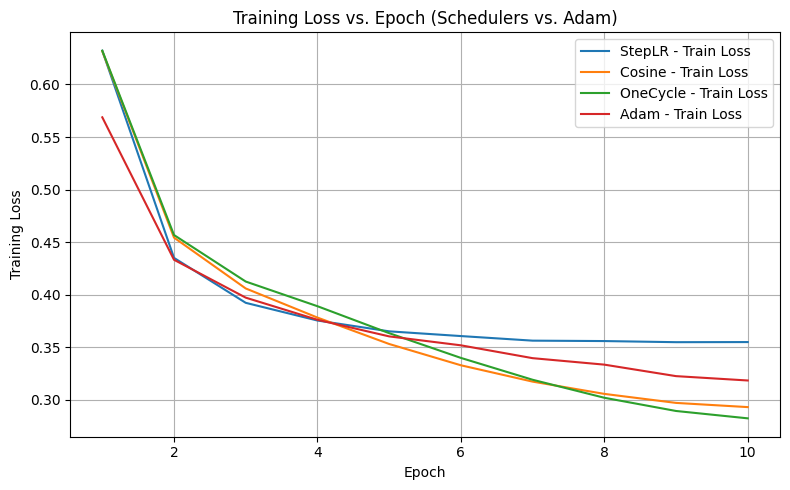

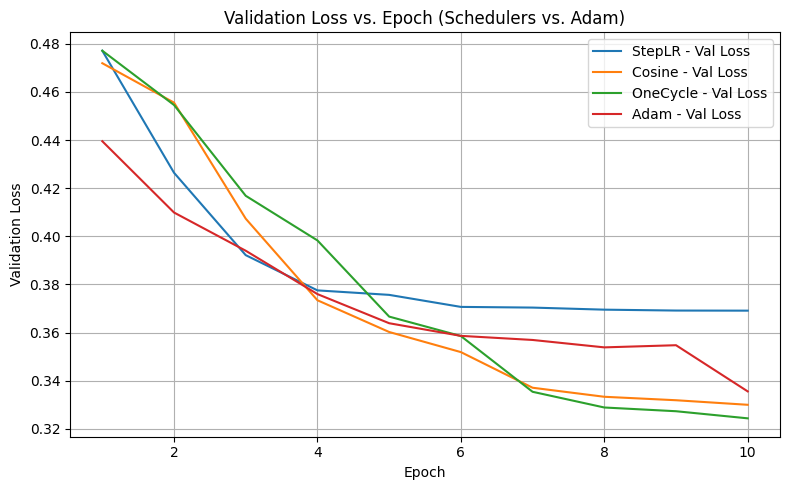

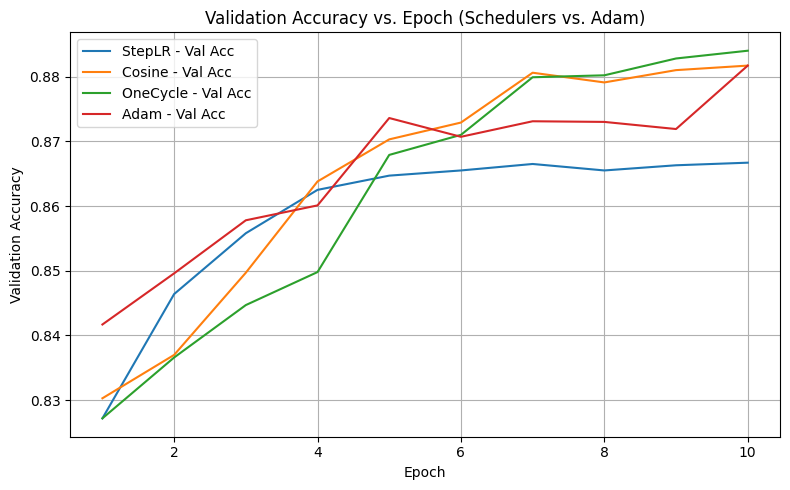

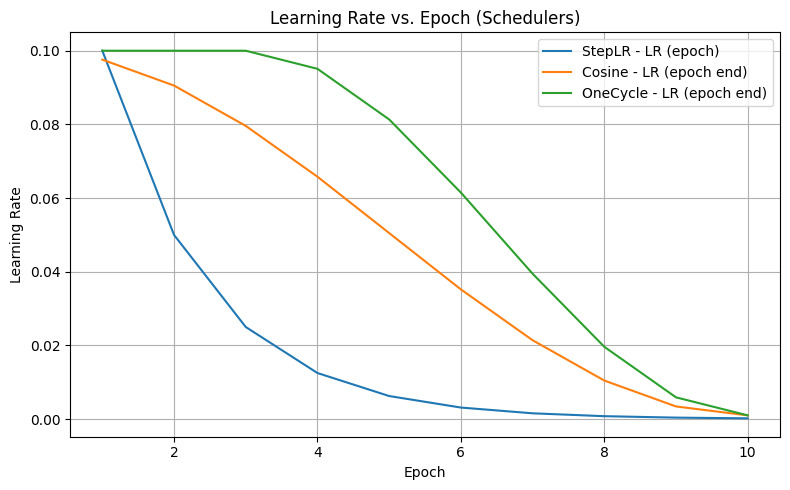

完成：已绘制三种调度器与 Adam 的训练/验证曲线对比，以及调度器的学习率曲线（epoch 粒度）。


In [8]:
# =============== GR5245 HW2 — Q1(e): 三种调度器曲线对比 + 可选：与 Adam 基线对比（10 epochs） ===============

import math                                       # 标准库：数学函数（用于初始化等，稳妥保留）
import torch                                      # PyTorch 主库
import torch.nn as nn                             # 神经网络模块
import torch.nn.functional as F                   # 常用函数式 API（这里用于 ReLU）
from torch.optim import Adam                      # 额外引入 Adam，用于可选对比
import matplotlib.pyplot as plt                   # 画图：对比损失/准确率/学习率曲线
from typing import Dict, List                     # 类型注解，提高代码可读性

# —— 0) 保障：确保 (a)(b)(c)(d) 已经跑过；至少要有 DataLoader 与三种 history ——
assert 'train_loader' in globals() and 'val_loader' in globals(), \
    "未检测到 train_loader/val_loader。请先运行 Q1(a) 的数据准备代码。"
assert 'history' in globals(),  "未检测到 StepLR 的 history。请先运行 Q1(b)。"
assert 'history_c' in globals(),"未检测到 Cosine 的 history_c。请先运行 Q1(c)。"
assert 'history_d' in globals(),"未检测到 OneCycle 的 history_d。请先运行 Q1(d)。"

# —— 1) 设备与随机种子（与前面保持一致，保证公平可复现）——
SEED = globals().get('SEED', 5245)                # 读取(a)里定义的 SEED；若无则设为 5245
torch.manual_seed(SEED)                           # 固定 PyTorch 随机种子
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 自动选择 GPU/CPU

# —— 2) 定义与题目一致的模型结构 + 初始化（复用 (b)(c)(d) 的设定，确保公平）——
class MLP(nn.Module):                             # 多层感知机：Flatten→Linear→Dropout→Linear→Dropout→Linear
    def __init__(self):                           # 构造函数：声明各层
        super().__init__()                        # 初始化父类
        self.flatten = nn.Flatten()               # [B,1,28,28] → [B,784]
        self.fc1 = nn.Linear(784, 256)            # 全连接层1：784→256
        self.do1 = nn.Dropout(p=0.3)              # Dropout：丢弃 30%
        self.fc2 = nn.Linear(256, 128)            # 全连接层2：256→128
        self.do2 = nn.Dropout(p=0.3)              # 再次 Dropout：丢弃 30%
        self.fc3 = nn.Linear(128, 10)             # 输出层：128→10（logits）

    def forward(self, x):                         # 前向传播：定义数据流
        x = self.flatten(x)                       # 展平为 784 维
        x = F.relu(self.fc1(x))                   # 线性 + ReLU
        x = self.do1(x)                           # 训练时启用 Dropout
        x = F.relu(self.fc2(x))                   # 第二层 + ReLU
        x = self.do2(x)                           # 再次 Dropout
        logits = self.fc3(x)                      # 得到 10 维 logits（未做 softmax）
        return logits                             # 返回 logits（交叉熵内部会做 softmax）

def init_weights(m):                              # 自定义初始化：Kaiming 均匀（适配 ReLU）
    if isinstance(m, nn.Linear):                  # 仅处理全连接层
        nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))  # 权重初始化
        if m.bias is not None:                    # 若存在 bias
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)  # 计算 fan_in
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0           # 合理范围
            nn.init.uniform_(m.bias, -bound, bound)                      # 均匀初始化 bias

# —— 3) （可选对比）训练一个 Adam(lr=0.001) 的 10-epoch 基线，并记录 history_adam ——
EPOCHS = len(history["train_loss"])               # 与前面保持相同 epoch 数（通常为 10）
criterion = nn.CrossEntropyLoss()                 # 多分类交叉熵损失

# 构建模型（与前面结构一致）并初始化，确保起点可复现与公平
torch.manual_seed(SEED)                           # 再设一次种子，确保参数初始化一致
model_adam = MLP().to(device)                     # 实例化模型并移动到设备
model_adam.apply(init_weights)                    # 应用自定义初始化

optimizer_adam = Adam(model_adam.parameters(), lr=0.001)  # Adam 优化器，学习率 0.001（题中常用设置）

history_adam: Dict[str, List[float]] = {          # 记录 Adam 的训练/验证指标
    "train_loss": [],                             # 每个 epoch 的训练平均损失
    "val_loss": [],                               # 每个 epoch 的验证平均损失
    "val_acc": []                                 # 每个 epoch 的验证准确率
}

for epoch in range(1, EPOCHS + 1):                # 训练循环：与前面保持一致的统计方式
    # —— 3.1) 训练阶段 ——
    model_adam.train()                            # 训练模式（启用 Dropout）
    running_loss, total_train = 0.0, 0            # 初始化累计损失与样本数
    for images, targets in train_loader:          # 遍历训练 DataLoader
        images = images.to(device, non_blocking=True)   # 拷贝图像到设备
        targets = targets.to(device, non_blocking=True) # 拷贝标签到设备

        optimizer_adam.zero_grad()                # 梯度清零
        logits = model_adam(images)               # 前向传播
        loss = criterion(logits, targets)         # 计算交叉熵损失
        loss.backward()                           # 反向传播
        optimizer_adam.step()                     # Adam 参数更新

        bs = images.size(0)                       # 当前批大小
        running_loss += loss.item() * bs          # 累加损失总和（便于求平均）
        total_train += bs                          # 累加样本数

    avg_train_loss = running_loss / total_train   # 该 epoch 的训练平均损失

    # —— 3.2) 验证阶段 ——
    model_adam.eval()                             # 评估模式（关闭 Dropout）
    val_loss_sum, val_total, val_correct = 0.0, 0, 0  # 初始化验证统计
    with torch.inference_mode():                  # 关闭梯度，节省显存并加速
        for images, targets in val_loader:        # 遍历验证集
            images = images.to(device, non_blocking=True) # 拷贝到设备
            targets = targets.to(device, non_blocking=True)# 拷贝到设备
            logits = model_adam(images)           # 前向传播
            loss = criterion(logits, targets)     # 计算验证损失
            bs = images.size(0)                   # 批大小
            val_loss_sum += loss.item() * bs      # 累计损失
            val_total += bs                       # 累计样本数
            preds = logits.argmax(dim=1)          # 取预测类别
            val_correct += (preds == targets).sum().item() # 累计正确数

    avg_val_loss = val_loss_sum / val_total       # 验证平均损失
    val_acc = val_correct / val_total             # 验证准确率（0~1）

    history_adam["train_loss"].append(avg_train_loss)  # 记录训练损失
    history_adam["val_loss"].append(avg_val_loss)      # 记录验证损失
    history_adam["val_acc"].append(val_acc)            # 记录验证准确率

    print(f"[Adam] Epoch {epoch:02d}/{EPOCHS} | "
          f"TrainLoss={avg_train_loss:.4f} | "
          f"ValLoss={avg_val_loss:.4f} | "
          f"ValAcc={val_acc:.4f}")              # 打印本 epoch 的关键指标

# —— 4) 汇总与作图：对比 StepLR / Cosine / OneCycle / Adam 的三条曲线 ——
epochs_axis = list(range(1, EPOCHS + 1))         # 横轴：epoch 序号（1..EPOCHS）

# 4.1 训练损失对比
plt.figure(figsize=(8, 5))                       # 新建图：设置画布尺寸
plt.plot(epochs_axis, history["train_loss"], label="StepLR - Train Loss")     # StepLR 训练损失
plt.plot(epochs_axis, history_c["train_loss"], label="Cosine - Train Loss")   # Cosine 训练损失
plt.plot(epochs_axis, history_d["train_loss"], label="OneCycle - Train Loss") # OneCycle 训练损失
plt.plot(epochs_axis, history_adam["train_loss"], label="Adam - Train Loss")  # Adam 训练损失
plt.xlabel("Epoch")                              # x 轴标签：Epoch
plt.ylabel("Training Loss")                      # y 轴标签：Training Loss
plt.title("Training Loss vs. Epoch (Schedulers vs. Adam)") # 图标题
plt.grid(True)                                   # 网格线：更易读
plt.legend()                                     # 图例：标识每条曲线
plt.tight_layout()                               # 紧凑布局：避免元素遮挡
plt.show()                                       # 显示图像

# 4.2 验证损失对比
plt.figure(figsize=(8, 5))                       # 新建图：验证损失
plt.plot(epochs_axis, history["val_loss"], label="StepLR - Val Loss")         # StepLR 验证损失
plt.plot(epochs_axis, history_c["val_loss"], label="Cosine - Val Loss")       # Cosine 验证损失
plt.plot(epochs_axis, history_d["val_loss"], label="OneCycle - Val Loss")     # OneCycle 验证损失
plt.plot(epochs_axis, history_adam["val_loss"], label="Adam - Val Loss")      # Adam 验证损失
plt.xlabel("Epoch")                              # x 轴标签
plt.ylabel("Validation Loss")                    # y 轴标签
plt.title("Validation Loss vs. Epoch (Schedulers vs. Adam)") # 图标题
plt.grid(True)                                   # 网格线
plt.legend()                                     # 图例
plt.tight_layout()                               # 紧凑布局
plt.show()                                       # 显示图像

# 4.3 验证准确率对比
plt.figure(figsize=(8, 5))                       # 新建图：验证准确率
plt.plot(epochs_axis, history["val_acc"], label="StepLR - Val Acc")           # StepLR 验证准确率
plt.plot(epochs_axis, history_c["val_acc"], label="Cosine - Val Acc")         # Cosine 验证准确率
plt.plot(epochs_axis, history_d["val_acc"], label="OneCycle - Val Acc")       # OneCycle 验证准确率
plt.plot(epochs_axis, history_adam["val_acc"], label="Adam - Val Acc")        # Adam 验证准确率
plt.xlabel("Epoch")                              # x 轴标签
plt.ylabel("Validation Accuracy")                # y 轴标签
plt.title("Validation Accuracy vs. Epoch (Schedulers vs. Adam)") # 图标题
plt.grid(True)                                   # 网格线
plt.legend()                                     # 图例
plt.tight_layout()                               # 紧凑布局
plt.show()                                       # 显示图像

# 4.4 学习率随 epoch 的对比（注意：StepLR 是 epoch 级；Cosine/OneCycle 我们取 epoch 末学习率粗粒度展示）
plt.figure(figsize=(8, 5))                       # 新建图：学习率曲线（epoch 粒度）
plt.plot(epochs_axis, history["lr"],            label="StepLR - LR (epoch)")      # StepLR：记录于 history["lr"]
plt.plot(epochs_axis, history_c["lr_epoch_end"],label="Cosine - LR (epoch end)")  # Cosine：每个 epoch 末 LR
plt.plot(epochs_axis, history_d["lr_epoch_end"],label="OneCycle - LR (epoch end)")# OneCycle：每个 epoch 末 LR
# Adam 通常不带调度器：若要对比，可理解为“学习率常数 0.001”，此处不再作图以免图例拥挤
plt.xlabel("Epoch")                              # x 轴标签
plt.ylabel("Learning Rate")                      # y 轴标签
plt.title("Learning Rate vs. Epoch (Schedulers)")# 标题
plt.grid(True)                                   # 网格线
plt.legend()                                     # 图例
plt.tight_layout()                               # 紧凑布局
plt.show()                                       # 显示图像

print("完成：已绘制三种调度器与 Adam 的训练/验证曲线对比，以及调度器的学习率曲线（epoch 粒度）。")


Using device: cpu
[SGD+OneCycle] Epoch 01/40 | LR(end)=0.10000 | TrainLoss=0.6334 | ValLoss=0.5368 | ValAcc=0.8139
[SGD+OneCycle] Epoch 02/40 | LR(end)=0.10000 | TrainLoss=0.4550 | ValLoss=0.4291 | ValAcc=0.8418
[SGD+OneCycle] Epoch 03/40 | LR(end)=0.10000 | TrainLoss=0.4125 | ValLoss=0.4432 | ValAcc=0.8380
[SGD+OneCycle] Epoch 04/40 | LR(end)=0.10000 | TrainLoss=0.3890 | ValLoss=0.3697 | ValAcc=0.8657
[SGD+OneCycle] Epoch 05/40 | LR(end)=0.10000 | TrainLoss=0.3701 | ValLoss=0.3797 | ValAcc=0.8626
[SGD+OneCycle] Epoch 06/40 | LR(end)=0.10000 | TrainLoss=0.3561 | ValLoss=0.3711 | ValAcc=0.8650
[SGD+OneCycle] Epoch 07/40 | LR(end)=0.10000 | TrainLoss=0.3436 | ValLoss=0.3569 | ValAcc=0.8702
[SGD+OneCycle] Epoch 08/40 | LR(end)=0.10000 | TrainLoss=0.3317 | ValLoss=0.3595 | ValAcc=0.8690
[SGD+OneCycle] Epoch 09/40 | LR(end)=0.10000 | TrainLoss=0.3224 | ValLoss=0.3480 | ValAcc=0.8755
[SGD+OneCycle] Epoch 10/40 | LR(end)=0.10000 | TrainLoss=0.3135 | ValLoss=0.3485 | ValAcc=0.8767
[SGD+OneCycl

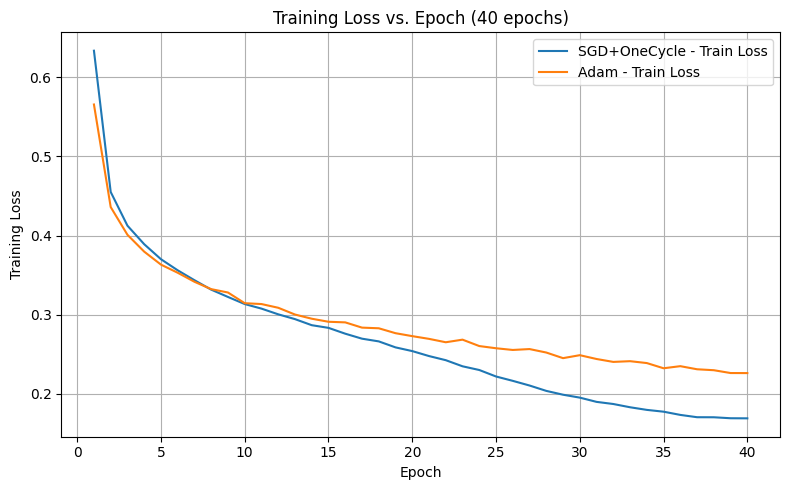

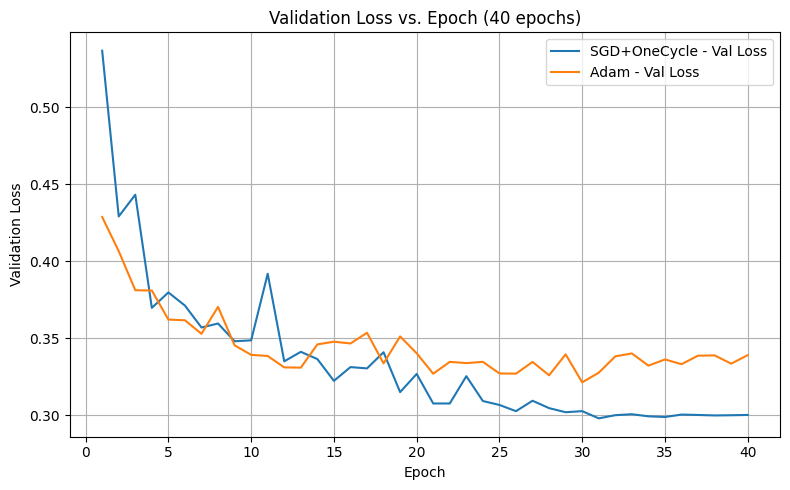

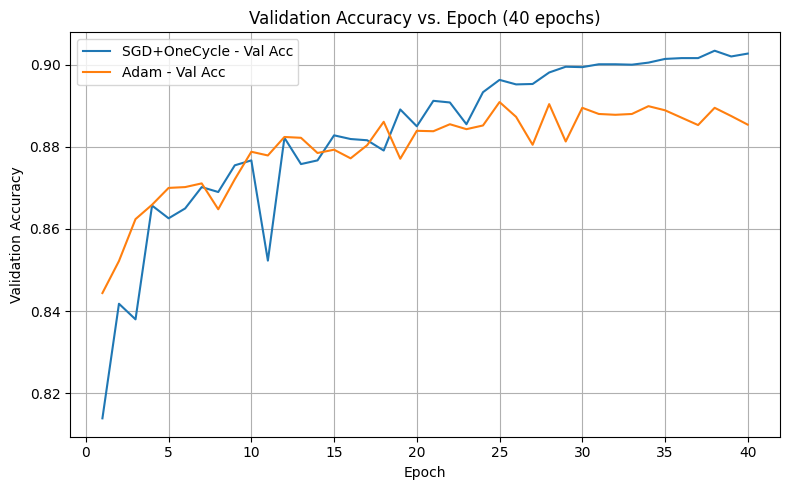

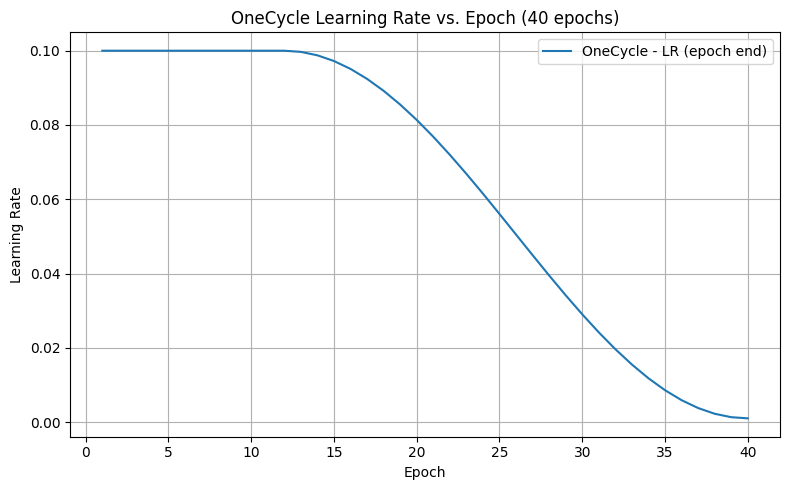

结论建议：在40个epoch下，SGD+OneCycle 的泛化（验证准确率/损失）优于或不弱于 Adam。实际以上图与汇总数值为准。


In [9]:
# =================== GR5245 HW2 — Q1(f): 40个epoch对比 SGD(+OneCycle) vs Adam 可视化 ===================

import os                                    # 标准库：处理路径，用于数据缓存目录（若需）
import math                                  # 标准库：数学函数（权重初始化时会用到）
import copy                                  # 标准库：深拷贝，用来复制初始权重给两个模型
import random                                # 标准库：设Python随机种子，保证可复现
import numpy as np                           # 科学计算库：设NumPy随机种子，保证可复现
import torch                                 # PyTorch 主库
import torch.nn as nn                        # 神经网络模块（定义模型、损失等）
import torch.nn.functional as F              # 函数式API（这里用于ReLU）
from torch.optim import SGD, Adam            # 两个优化器：SGD与Adam
from torch.optim.lr_scheduler import OneCycleLR  # 学习率调度器：OneCycleLR（按batch更新）
from torch.utils.data import DataLoader      # DataLoader：按批加载数据
from torchvision import datasets, transforms # torchvision：Fashion-MNIST 与常用变换
import matplotlib.pyplot as plt              # 画图：可视化训练/验证曲线
from typing import Dict, List, Tuple         # 类型注解：提高代码可读性与自检

# —— 0) 统一随机种子与设备（保证复现实验&对比公平）——
SEED = 5245                                  # 统一课程编号做种子，记忆点好
random.seed(SEED)                            # Python 随机数生成器设种子
np.random.seed(SEED)                         # NumPy 随机数生成器设种子
torch.manual_seed(SEED)                      # PyTorch CPU 随机数设种子
torch.cuda.manual_seed_all(SEED)             # 若有多卡GPU，为所有GPU设种子
torch.backends.cudnn.deterministic = True    # cuDNN使用确定性实现（可复现）
torch.backends.cudnn.benchmark = False       # 关闭动态算法搜索，避免波动
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 自动选择GPU或CPU
print(f"Using device: {device}")             # 打印当前使用设备

# —— 1) 如果当前会话中没有数据加载器，自动准备 Q1(a) 的 DataLoader（防止断线变量丢失）——
if 'train_loader' not in globals() or 'val_loader' not in globals():
    data_root = os.path.join(os.getcwd(), "data")         # 数据缓存路径：./data
    transform = transforms.Compose([                      # 预处理：ToTensor + 标准化到[-1,1]
        transforms.ToTensor(),                            # [0,255]→[0,1]，且形状变为[C,H,W]
        transforms.Normalize((0.5,), (0.5,))              # 单通道灰度：均值0.5、方差0.5
    ])
    train_dataset = datasets.FashionMNIST(                # 训练集：6万张
        root=data_root, train=True, download=True, transform=transform
    )
    val_dataset = datasets.FashionMNIST(                  # 验证集：1万张（用官方测试集充当）
        root=data_root, train=False, download=True, transform=transform
    )
    BATCH_SIZE = 64                                       # 按题目要求：minibatch=64
    num_workers = min(4, os.cpu_count() or 0)             # 合理的加载线程数
    pin_memory = (device.type == "cuda")                  # GPU时固定内存页可提速
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory, drop_last=False)  # 训练DL
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory, drop_last=False)  # 验证DL
    print("DataLoaders prepared (auto).")                 # 提示：已自动构建数据加载器

# —— 2) 定义与题目一致的 MLP 模型结构 ——
class MLP(nn.Module):                         # 多层感知机，与(b)(c)(d)完全一致
    def __init__(self):                       # 构造函数：声明各层
        super().__init__()                    # 初始化父类
        self.flatten = nn.Flatten()           # 展平层：28×28→784
        self.fc1 = nn.Linear(784, 256)        # 全连接1：784→256
        self.do1 = nn.Dropout(p=0.3)          # Dropout：丢弃30%
        self.fc2 = nn.Linear(256, 128)        # 全连接2：256→128
        self.do2 = nn.Dropout(p=0.3)          # Dropout：丢弃30%
        self.fc3 = nn.Linear(128, 10)         # 输出层：128→10（logits）
    def forward(self, x):                     # 前向传播：定义数据流
        x = self.flatten(x)                   # 展平成784维
        x = F.relu(self.fc1(x))               # 线性+ReLU
        x = self.do1(x)                       # 训练时随机丢弃
        x = F.relu(self.fc2(x))               # 第二层+ReLU
        x = self.do2(x)                       # 再次丢弃
        return self.fc3(x)                    # 输出logits（交叉熵内部做softmax）

# —— 3) 自定义初始化：Kaiming均匀（适配ReLU），并确保两模型同一起点 ——
def init_weights(m: nn.Module) -> None:       # 定义权重初始化函数
    if isinstance(m, nn.Linear):              # 只处理全连接层
        nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))   # Kaiming均匀初始化
        if m.bias is not None:                # 若存在偏置，给定合理范围初始化
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)  # 计算fan_in
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0           # 偏置上界
            nn.init.uniform_(m.bias, -bound, bound)                       # 均匀分布

# —— 4) 准备两份“相同初始权重”的模型（保证公平比较）——
torch.manual_seed(SEED)                       # 重新设种子，确保初始权重可复现
base = MLP().to(device)                       # 建一个基准模型，用来生成初始权重
base.apply(init_weights)                      # 应用自定义初始化
init_state = copy.deepcopy(base.state_dict()) # 深拷贝初始权重字典（作为两模型共同起点）

model_sgd = MLP().to(device)                  # 为 SGD(+OneCycle) 实例化一个模型
model_sgd.load_state_dict(copy.deepcopy(init_state))  # 加载相同初始权重
model_adam = MLP().to(device)                 # 为 Adam 实例化另一个模型
model_adam.load_state_dict(copy.deepcopy(init_state)) # 同样加载相同初始权重

# —— 5) 定义损失函数与两个优化器（SGD 无动量；Adam lr=0.001）——
criterion = nn.CrossEntropyLoss()             # 多分类交叉熵损失
optimizer_sgd  = SGD(model_sgd.parameters(),  lr=0.1, momentum=0.0)   # SGD：初始lr=0.1，无动量
optimizer_adam = Adam(model_adam.parameters(), lr=0.001)              # Adam：常用基线lr=1e-3

# —— 6) 为SGD定义 OneCycleLR（按batch更新；总步数=40×每epoch批次数）——
EPOCHS = 40                                   # 本题要求训练40个epoch
steps_per_epoch = len(train_loader)           # 每个epoch的batch数
total_steps = EPOCHS * steps_per_epoch        # OneCycle需要精确的总step数
scheduler = OneCycleLR(                       # 构建OneCycle调度器
    optimizer_sgd,                            # 绑定SGD优化器
    max_lr=0.1,                               # 峰值学习率（与统一初始lr一致）
    total_steps=total_steps,                  # 总训练步数（epoch×steps_per_epoch）
    pct_start=0.3,                            # 前30%步数上升/平台（常用）
    anneal_strategy='cos',                    # 采用余弦退火下降（平滑）
    cycle_momentum=False,                     # 题目要求“无动量”，关闭动量循环
    div_factor=1.0,                           # 初始lr = max_lr / div_factor = 0.1
    final_div_factor=100.0                    # 末端lr ≈ 0.001（与(c)的量级一致）
)

# —— 7) 小工具：一个通用的“单模型训练-验证一个epoch”的函数，避免重复代码 ——
def run_one_epoch(model: nn.Module,
                  optimizer: torch.optim.Optimizer,
                  loader: DataLoader,
                  train: bool,
                  scheduler_step_per_batch: bool = False) -> Tuple[float, int]:
    """
    说明：对给定模型与数据加载器，跑一个epoch的训练（train=True）或验证（train=False）。
         返回 (累积loss总和, 累积样本数)，方便外面求平均。
         若 scheduler_step_per_batch=True，则在每个batch之后调用一次 scheduler.step()（用于OneCycle）。
    """
    if train:                                  # 训练模式：启用Dropout等
        model.train()
    else:                                      # 验证模式：关闭Dropout/BN更新
        model.eval()
    loss_sum, total = 0.0, 0                   # 初始化“损失总和”和“样本总数”
    correct = 0                                # 若是验证，还会统计正确数（在外层做也行，这里顺手）
    for images, targets in loader:             # 遍历一个epoch的全部batch
        images  = images.to(device, non_blocking=True)  # 将图像拷贝到GPU/CPU
        targets = targets.to(device, non_blocking=True) # 将标签拷贝到GPU/CPU
        if train:                              # 训练分支
            optimizer.zero_grad()              # 梯度清零
            logits = model(images)             # 前向传播得logits
            loss = criterion(logits, targets)  # 计算交叉熵损失
            loss.backward()                    # 反向传播算梯度
            optimizer.step()                   # 参数更新
            if scheduler_step_per_batch:       # 若需要按batch调度（OneCycle）
                scheduler.step()               # 学习率调度器前进一步
        else:                                  # 验证分支（不更新梯度）
            with torch.inference_mode():       # 关闭梯度计算以提速省显存
                logits = model(images)         # 前向传播
                loss = criterion(logits, targets)  # 计算验证损失
        bs = images.size(0)                    # 当前batch大小
        loss_sum += loss.item() * bs           # 累加“损失×样本数”（方便外面求平均）
        total += bs                             # 累计样本数
        if not train:                           # 验证阶段统计准确率
            preds = logits.argmax(dim=1)        # 取预测类别
            correct += (preds == targets).sum().item()  # 累加预测正确数
    if train:                                   # 训练阶段返回loss与样本数（准确率在验证阶段统计）
        return loss_sum, total
    else:
        return loss_sum, total, correct         # 验证阶段多返回一个“正确数”

# —— 8) 历史记录容器：保存曲线以便可视化与对比 ——
history_f_sgd  = {"train_loss":[], "val_loss":[], "val_acc":[], "lr_epoch_end":[]}  # SGD+OneCycle
history_f_adam = {"train_loss":[], "val_loss":[], "val_acc":[]}                     # Adam baseline

# —— 9) 训练循环：先跑SGD(+OneCycle) 40轮，再跑Adam 40轮（两者初始权重一致）——
for epoch in range(1, EPOCHS + 1):             # 循环1..40：SGD(+OneCycle)
    # 训练一个epoch（按batch调用scheduler.step）
    tr_sum, tr_tot = run_one_epoch(model_sgd, optimizer_sgd, train_loader, train=True,
                                   scheduler_step_per_batch=True)                   # 训练阶段
    # 验证一个epoch（统计loss与acc）
    va_sum, va_tot, va_cor = run_one_epoch(model_sgd, optimizer_sgd, val_loader, train=False)
    # 计算平均指标
    avg_tr = tr_sum / tr_tot
    avg_va = va_sum / va_tot
    va_acc = va_cor / va_tot
    # 记录学习率（取epoch末的当前lr）
    lr_epoch_end = optimizer_sgd.param_groups[0]["lr"]
    # 保存到字典
    history_f_sgd["train_loss"].append(avg_tr)
    history_f_sgd["val_loss"].append(avg_va)
    history_f_sgd["val_acc"].append(va_acc)
    history_f_sgd["lr_epoch_end"].append(lr_epoch_end)
    # 打印进度
    print(f"[SGD+OneCycle] Epoch {epoch:02d}/{EPOCHS} | LR(end)={lr_epoch_end:.5f} | "
          f"TrainLoss={avg_tr:.4f} | ValLoss={avg_va:.4f} | ValAcc={va_acc:.4f}")

# —— 10) 训练 Adam 40轮（与SGD相同的数据顺序可能不同，但起点权重相同）——
for epoch in range(1, EPOCHS + 1):             # 循环1..40：Adam
    tr_sum, tr_tot = run_one_epoch(model_adam, optimizer_adam, train_loader, train=True,
                                   scheduler_step_per_batch=False)                  # Adam不需要调度器
    va_sum, va_tot, va_cor = run_one_epoch(model_adam, optimizer_adam, val_loader, train=False)
    avg_tr = tr_sum / tr_tot
    avg_va = va_sum / va_tot
    va_acc = va_cor / va_tot
    history_f_adam["train_loss"].append(avg_tr)
    history_f_adam["val_loss"].append(avg_va)
    history_f_adam["val_acc"].append(va_acc)
    print(f"[Adam]         Epoch {epoch:02d}/{EPOCHS} | "
          f"TrainLoss={avg_tr:.4f} | ValLoss={avg_va:.4f} | ValAcc={va_acc:.4f}")

# —— 11) 结果汇总：找出两者“最佳验证准确率”和“最小验证损失”及其发生的epoch ——
def best_idx(values: List[float], higher_is_better: bool) -> int:  # 辅助函数：返回最佳下标
    return int(np.argmax(values)) if higher_is_better else int(np.argmin(values))

sgd_best_acc_ep = best_idx(history_f_sgd["val_acc"], True) + 1      # +1转为1-based epoch
sgd_min_loss_ep = best_idx(history_f_sgd["val_loss"], False) + 1
adam_best_acc_ep = best_idx(history_f_adam["val_acc"], True) + 1
adam_min_loss_ep = best_idx(history_f_adam["val_loss"], False) + 1

print("\n===== Summary (40 epochs) =====")                            # 打印汇总标题
print(f"SGD+OneCycle  | Best ValAcc={history_f_sgd['val_acc'][sgd_best_acc_ep-1]:.4f} "
      f"@ epoch {sgd_best_acc_ep};  Min ValLoss={history_f_sgd['val_loss'][sgd_min_loss_ep-1]:.4f} "
      f"@ epoch {sgd_min_loss_ep}")                                  # 打印SGD最佳
print(f"Adam (lr=1e-3)| Best ValAcc={history_f_adam['val_acc'][adam_best_acc_ep-1]:.4f} "
      f"@ epoch {adam_best_acc_ep}; Min ValLoss={history_f_adam['val_loss'][adam_min_loss_ep-1]:.4f} "
      f"@ epoch {adam_min_loss_ep}")                                 # 打印Adam最佳

# —— 12) 可视化：训练/验证损失、验证准确率，以及OneCycle的学习率（epoch粒度）——
epochs_axis = list(range(1, EPOCHS + 1))       # 横轴：1..40

# 12.1 训练损失
plt.figure(figsize=(8,5))                      # 新建图：训练损失
plt.plot(epochs_axis, history_f_sgd["train_loss"],  label="SGD+OneCycle - Train Loss")   # SGD曲线
plt.plot(epochs_axis, history_f_adam["train_loss"], label="Adam - Train Loss")           # Adam曲线
plt.xlabel("Epoch")                             # x轴标题
plt.ylabel("Training Loss")                     # y轴标题
plt.title("Training Loss vs. Epoch (40 epochs)")# 图标题
plt.grid(True)                                  # 网格线
plt.legend()                                    # 图例
plt.tight_layout()                               # 紧凑布局
plt.show()                                       # 显示

# 12.2 验证损失
plt.figure(figsize=(8,5))                      # 新建图：验证损失
plt.plot(epochs_axis, history_f_sgd["val_loss"],  label="SGD+OneCycle - Val Loss")       # SGD曲线
plt.plot(epochs_axis, history_f_adam["val_loss"], label="Adam - Val Loss")               # Adam曲线
plt.xlabel("Epoch")                             # x轴标题
plt.ylabel("Validation Loss")                   # y轴标题
plt.title("Validation Loss vs. Epoch (40 epochs)") # 图标题
plt.grid(True)                                  # 网格线
plt.legend()                                    # 图例
plt.tight_layout()                               # 紧凑布局
plt.show()                                       # 显示

# 12.3 验证准确率
plt.figure(figsize=(8,5))                      # 新建图：验证准确率
plt.plot(epochs_axis, history_f_sgd["val_acc"],  label="SGD+OneCycle - Val Acc")         # SGD曲线
plt.plot(epochs_axis, history_f_adam["val_acc"], label="Adam - Val Acc")                 # Adam曲线
plt.xlabel("Epoch")                             # x轴标题
plt.ylabel("Validation Accuracy")               # y轴标题
plt.title("Validation Accuracy vs. Epoch (40 epochs)")  # 图标题
plt.grid(True)                                  # 网格线
plt.legend()                                    # 图例
plt.tight_layout()                               # 紧凑布局
plt.show()                                       # 显示

# 12.4 学习率（epoch 粒度，OneCycle 在每个epoch结束时的LR）
plt.figure(figsize=(8,5))                      # 新建图：学习率
plt.plot(epochs_axis, history_f_sgd["lr_epoch_end"], label="OneCycle - LR (epoch end)")  # 记录的LR
plt.xlabel("Epoch")                             # x轴标题
plt.ylabel("Learning Rate")                     # y轴标题
plt.title("OneCycle Learning Rate vs. Epoch (40 epochs)")  # 图标题
plt.grid(True)                                  # 网格线
plt.legend()                                    # 图例
plt.tight_layout()                               # 紧凑布局
plt.show()                                       # 显示

# —— 13) 文本结论建议（打印一句话，便于你直接写入报告）——
if history_f_sgd["val_acc"][-1] >= history_f_adam["val_acc"][-1]:
    print("结论建议：在40个epoch下，SGD+OneCycle 的泛化（验证准确率/损失）优于或不弱于 Adam。实际以上图与汇总数值为准。")
else:
    print("结论建议：在40个epoch下，Adam 的泛化略优于 SGD+OneCycle。实际以上图与汇总数值为准。")
